<center>
<a href="https://exed.polytechnique.edu/fr" ><img src="https://exed.polytechnique.edu/sites/all/themes/college/images/logo.png" style="float:left; max-width: 360px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Scénarios d'Apprentissage Statistique] 

# GRC: Score d'appétence d'un produit bancaire  en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-learn"/></a>

#### Résumé
Les données sont composées de 825 clients d'une banque décrits par 32 variables concernant leurs avoirs, et utilisations de leurs comptes. Le premier objectif est une exploration du jeu de données, une segmentation ou profilage des types de comportement des clients, le 2ème consiste à estimer puis prévoir un *score d'appétence* pour un produit bancaie, ici la carte visa premier. Comparaison des différentes méthodes et algorihtmes d'apprentissage pour atteindre cet objectif de la régression logistique au *boosting* (*extrem gradient*) en passant par les arbres, les SVM ou random forest. Une procédure de validation croisée généralisée est itérée sur une selection de ces méthodes. Celles d'agrégation de modèles conduisent aux meilleurs résultats. 

## Introduction


### Présentation des données
#### Les variables
La liste des variables est issue d'une base de données retraçant l'historique mensuel bancaire et les caractéristiques de tous les clients. Un sondage a été réalisé afin d'alléger les traitements ainsi qu'une première sélection de variables. Les variables contenues dans le fichier initial sont décrites dans le tableau ci-dessous. Elles sont observées sur 1425 clients.

*Tableau: Liste des variables initiales et de leur libellé* Attention, certains sont écrits en majuscules dans les programmes puis en minuscules après transfomation des données (logarithme, recodage) au cours d ela phase d'exploration. Les noms des variables logarithmes des variables quantitatives se terminent par `L`les variables qualitatives se terminent par `Q`ou `q`. 

**Identifiant** | **Libellé**
           --|--
`sexeq` | Sexe (qualitatif) 
`ager` | Age en années
`famiq` | Situation familiale: `Fmar Fcel Fdiv Fuli Fsep Fveu`
`relat` | Ancienneté de relation en mois
`pcspq` | Catégorie socio-professionnelle (code num)
`opgnb` | Nombre d'opérations par guichet dans le mois
`moyrv` | Moyenne des mouvements nets créditeurs des 3 mois en Kf
`tavep` | Total des avoirs épargne monétaire en francs
`endet` | Taux d'endettement
`gaget` | Total des engagements en francs
`gagec` | Total des engagements court terme en francs
`gagem` | Total des engagements moyen terme en francs
`kvunb` | Nombre de comptes à vue
`qsmoy` | Moyenne des soldes moyens sur 3 mois
`qcred` | Moyenne des mouvements créditeurs en Kf
`dmvtp` | Age du dernier mouvement (en jours)\hline
`boppn` | Nombre d'opérations à M-1
`facan` | Montant facturé dans l'année en francs
`lgagt` | Engagement long terme
`vienb` | Nombre de produits contrats vie
`viemt` | Montant des produits contrats vie en francs
`uemnb` | Nombre de produits épargne monétaire
`xlgnb` | Nombre de produits d'épargne logement
`xlgmt` | Montant des produits d'épargne logement en francs
`ylvnb` | Nombre de comptes sur livret
`ylvmt` | Montant des comptes sur livret en francs
`rocnb` | Nombre de paiements par carte bancaire à M-1
`nptag` | Nombre de cartes point argent
`itavc` | Total des avoirs sur tous les comptes
`havef` | Total des avoirs épargne financière en francs
`jnbjd | Nombre de jours à débit à M
**`carvp`** | **Possession de la carte VISA Premier**

#### Remarque importante: 


<center>
<img src="http://www.cmap.polytechnique.fr/~aymeric.dieuleveut/papers/This-is-ML-pipe" style="float:left; max-width: 600px; display: inline" alt="INSA"/></center>
<br>


Voir par exemple: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7


In [118]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import decomposition # PCA et NMF
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score , RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
sns.set()

In [3]:
data = pd.read_table('vispremv.dat', delimiter = ' ')

In [4]:
data.head()

,SEXEQ,FAMIQ,PCSPQ,kvunbq,vienbq,uemnbq,xlgnbq,ylvnbq,rocnbq,nptagq,...,XLGNB,XLGMTL,YLVNB,YLVMTL,ROCNB,NPTAG,ITAVCL,HAVEFL,JNBJDL,CARVP
148009,Shom,Fcou,Pint,K1,V1,U2,X2,Y2,R1,N0,...,2,13.161865,2,12.110635,14,0,14.080718,13.230263,0.693147,Coui
552427,Shom,Fcou,Pint,K0,V0,U1,X0,Y1,R0,N0,...,0,0.000000,1,8.132413,0,0,11.717872,0.000000,0.000000,Coui
556005,Shom,Fseu,Psan,K0,V0,U2,X1,Y2,R1,N0,...,1,10.743178,2,10.309286,14,0,11.329303,0.000000,0.000000,Coui
556686,Shom,Fseu,Pouv,K0,V1,U2,X2,Y2,R1,N1,...,3,12.899220,2,11.203025,11,1,13.111856,9.972267,2.772589,Coui
642680,Shom,Fcou,Pint,K0,V0,U2,X1,Y2,R1,N0,...,1,10.457976,2,9.190546,27,0,11.304904,0.000000,1.386294,Coui


In [5]:
data.describe()

,RELAT,AGER,OPGNBL,MOYRVL,TAVEPL,ENDETL,GAGETL,GAGECL,GAGEML,KVUNB,...,UEMNB,XLGNB,XLGMTL,YLVNB,YLVMTL,ROCNB,NPTAG,ITAVCL,HAVEFL,JNBJDL
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,132.574788,42.573848,0.627211,2.371296,6.715418,0.827903,4.477338,1.868891,2.394713,1.028222,...,1.468485,0.649106,4.161701,0.760113,4.726685,8.564440,0.136406,9.373976,3.043170,1.189791
std,93.499830,11.912343,0.685315,1.464376,4.907295,1.279475,5.473534,3.680483,4.540024,0.501554,...,1.280262,0.794352,5.205502,0.782235,4.662683,11.738092,0.379837,3.313518,4.665580,1.587594
min,-2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.500000,33.000000,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.067305,0.000000,0.000000
50%,130.000000,43.000000,0.693147,2.564949,8.652248,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,4.882802,2.000000,0.000000,10.075969,0.000000,0.000000
75%,204.500000,52.000000,1.098612,3.349750,10.962298,1.945910,10.483833,0.000000,0.000000,1.000000,...,2.000000,1.000000,10.033572,1.000000,9.651494,14.000000,0.000000,11.649131,6.216606,2.441401
max,393.000000,65.000000,3.367296,7.451242,13.785052,4.605170,15.060512,13.123924,14.296852,4.000000,...,9.000000,4.000000,13.270100,4.000000,13.785052,69.000000,4.000000,16.045468,15.770893,4.905275


In [6]:
print("nombre de lignes (donc de contrats) :",data.shape[0])
print("nombre de variables :", data.shape[1])

nombre de lignes (donc de contrats) : 1063
nombre de variables : 54


In [177]:
data.CARVP = data.CARVP.replace('Coui',1)
data.CARVP = data.CARVP.replace('Cnon',0)
data=data.sample(frac=1) 
data.CARVP

2649790    0
443514     0
1147222    0
1471063    0
2347218    1
          ..
2557961    0
1564834    0
148009     1
179072     0
3444169    1
Name: CARVP, Length: 1063, dtype: int64

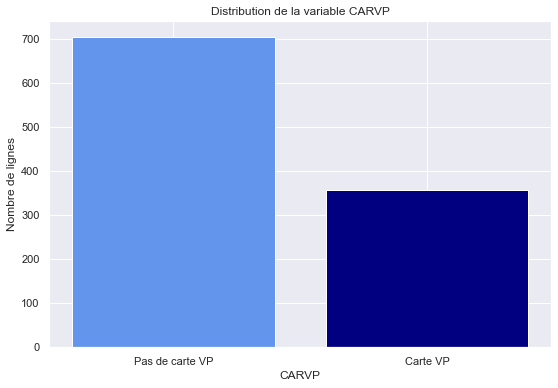

In [181]:
plt.figure(figsize=(9,6))
plt.bar(["Pas de carte VP", "Carte VP"], height= data.groupby("CARVP").count().SEXEQ, color=('cornflowerblue', 'navy'))
plt.xlabel("CARVP")
plt.ylabel("Nombre de lignes")
plt.title("Distribution de la variable CARVP");

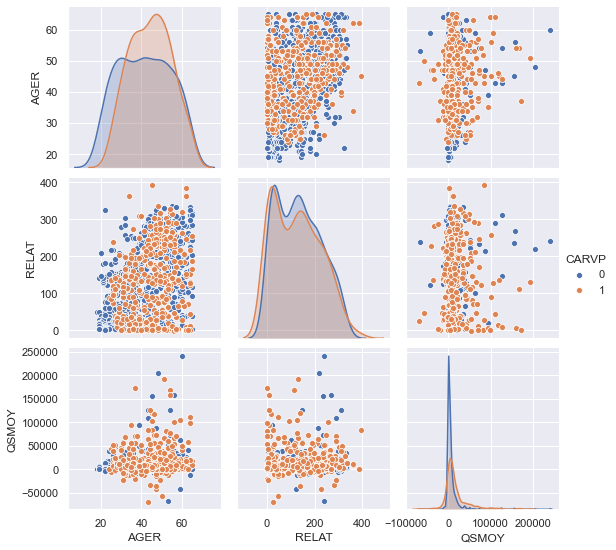

In [120]:
sns.pairplot(data[["AGER", "RELAT", "PCSPQ", "CARVP", "QSMOY"]], hue="CARVP");

In [140]:
Nb_NA = data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 148009 to 7589439
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEXEQ   1063 non-null   object 
 1   FAMIQ   1063 non-null   object 
 2   PCSPQ   1063 non-null   object 
 3   kvunbq  1063 non-null   object 
 4   vienbq  1063 non-null   object 
 5   uemnbq  1063 non-null   object 
 6   xlgnbq  1063 non-null   object 
 7   ylvnbq  1063 non-null   object 
 8   rocnbq  1063 non-null   object 
 9   nptagq  1063 non-null   object 
 10  endetq  1063 non-null   object 
 11  gagetq  1063 non-null   object 
 12  facanq  1063 non-null   object 
 13  lgagtq  1063 non-null   object 
 14  havefq  1063 non-null   object 
 15  jnbjdq  1063 non-null   object 
 16  ageq    1063 non-null   object 
 17  relatq  1063 non-null   object 
 18  qsmoyq  1063 non-null   object 
 19  opgnbq  1063 non-null   object 
 20  moyrvq  1063 non-null   object 
 21  tavepq  1063 non-null   objec

In [10]:
Y = data['CARVP']
X = data.drop(columns='CARVP')
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

### Preprocessing

In [168]:
numerical_col = X.select_dtypes( exclude = object ).columns
categorical_col = X.select_dtypes( include = object ).columns

preprocessor = make_column_transformer(
                                        (OneHotEncoder(), categorical_col),
                                        (StandardScaler(), numerical_col)
                                       )

pipeline_Rforest = make_pipeline(preprocessor, RandomForestClassifier())

pipeline_Lregressor = make_pipeline(preprocessor, LogisticRegression())

pipeline_XGBoost = make_pipeline(preprocessor, GradientBoostingClassifier())

### Tuning des hyperparamètres

#### Gradient Boosting

In [93]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [126]:
parameters = {'gradientboostingclassifier__n_estimators': [i for i in range(1,100)],
             'gradientboostingclassifier__learning_rate': [i for i in np.arange(0.01,1,0.1)], 
             'gradientboostingclassifier__max_depth': [i for i in range(1,200)]}
XGBoost_cv = RandomizedSearchCV(pipeline_XGBoost,parameters, cv=5, n_iter = 70, scoring='roc_auc')
XGBoost_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               Index(['SEXEQ', 'FAMIQ', 'PCSPQ', 'kvunbq', 'vienbq', 'uemnbq', 'xlgnbq',
       'ylvnbq', 'rocnbq', 'nptagq', 'endetq', 'gagetq', 'facanq', 'lgagtq',
       'havefq', 'jnbjdq', 'ageq', 'relatq', 'qsmoyq', 'opgnbq', 'moyrvq',
       'tavepq', 'dmvtpq', 'bopp...
                                                                                      0.41000000000000003,
                                                                                      0.51,
                                                                                      0.6100000000000001,
                                                                      

In [111]:
XGBoost_cv.best_estimator_.steps[-1][1]

GradientBoostingClassifier(learning_rate=0.51, max_depth=4, n_estimators=10)

#### Random Forest

In [127]:
parameters = {'randomforestclassifier__n_estimators' : [i for i in range(50,400)],
              'randomforestclassifier__max_depth' : [i for i in range(5,20)]}   
Rforest_cv = RandomizedSearchCV(pipeline_Rforest, parameters, cv=5, scoring='roc_auc')
Rforest_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               Index(['SEXEQ', 'FAMIQ', 'PCSPQ', 'kvunbq', 'vienbq', 'uemnbq', 'xlgnbq',
       'ylvnbq', 'rocnbq', 'nptagq', 'endetq', 'gagetq', 'facanq', 'lgagtq',
       'havefq', 'jnbjdq', 'ageq', 'relatq', 'qsmoyq', 'opgnbq', 'moyrvq',
       'tavepq', 'dmvtpq', 'bopp...
       'YLVNB', 'YLVMTL', 'ROCNB', 'NPTAG', 'ITAVCL', 'HAVEFL', 'JNBJDL'],
      dtype='object'))])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                             

#### Régression logistique

In [98]:
parameters = {'logisticregression__C' : np.logspace(-4, 4, 20)}   
LRegressor_cv = RandomizedSearchCV(pipeline_Lregressor, parameters, n_jobs=-1, cv=5, verbose=True, scoring="roc_auc")
LRegressor_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               Index(['SEXEQ', 'FAMIQ', 'PCSPQ', 'kvunbq', 'vienbq', 'uemnbq', 'xlgnbq',
       'ylvnbq', 'rocnbq', 'nptagq', 'endetq', 'gagetq', 'facanq', 'lgagtq',
       'havefq', 'jnbjdq', 'ageq', 'relatq', 'qsmoyq', 'opgnbq', 'moyrvq',
       'tavepq', 'dmvtpq', 'bopp...
                   param_distributions={'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.4

### Evaluation et comparaison des modèles

In [138]:
XGBoost_scores_cv = pd.DataFrame(XGBoost_cv.cv_results_)
scores_xgb_auc = XGBoost_scores_cv.loc[XGBoost_cv.best_index_,"split0_test_score":"split4_test_score"].values
Rforest_scores_cv = pd.DataFrame(Rforest_cv.cv_results_)
scores_rf_auc = Rforest_scores_cv.loc[Rforest_cv.best_index_,"split0_test_score":"split4_test_score"].values
LRegressor_scores_cv = pd.DataFrame(LRegressor.cv_results_)
scores_lr_auc = LRegressor_scores_cv.loc[LRegressor.best_index_,"split0_test_score":"split4_test_score"].values

In [186]:
scores_lr_auc

array([0.9182573891625616, 0.9322660098522169, 0.9207204433497538,
       0.9189189189189189, 0.8900595510765001], dtype=object)

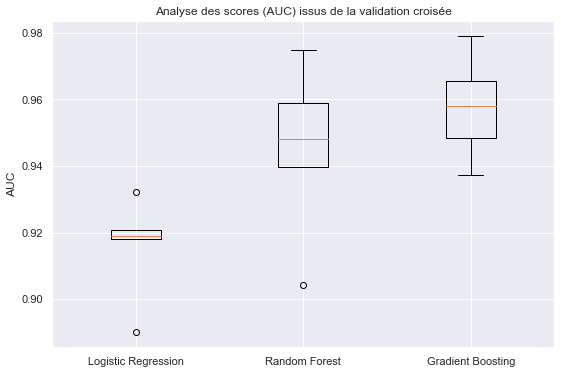

In [139]:
plt.figure(figsize=(9,6))
plt.boxplot([scores_lr_auc, scores_rf_auc, scores_xgb_auc])
plt.title("Analyse des scores (AUC) issus de la validation croisée")
plt.xticks([1, 2, 3], ["Logistic Regression", "Random Forest", "Gradient Boosting"])
plt.ylabel("AUC");

### Courbe ROC

In [ ]:
y_pred_proba_lr = LRegressor_cv.predict_proba(X_test)[:,1]
y_pred_proba_rf = Rforest_cv.predict_proba(X_test)[:,1]
y_pred_proba_gb = XGBoost_cv.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)

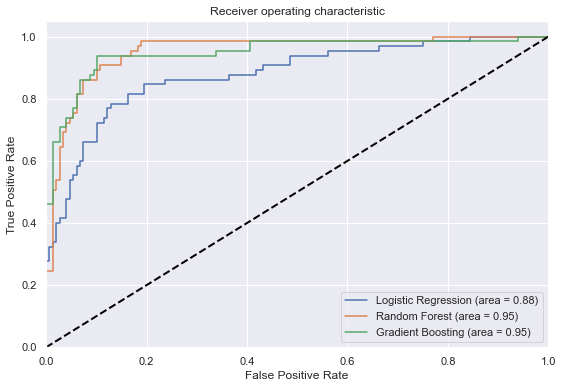

In [129]:
plt.figure(figsize=(9,6))
plt.plot(fpr_lr, tpr_lr, 
        label='Logistic Regression (area = %0.2f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_rf, tpr_rf, 
        label='Random Forest (area = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot(fpr_gb, tpr_gb, 
        label='Gradient Boosting (area = %0.2f)' % auc(fpr_gb, tpr_gb))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Autres métriques

In [170]:
accuracy,f1,recall,precision = [],[],[],[]

for estimator in [LRegressor_cv,Rforest_cv,XGBoost_cv] : 
    accuracy.append(accuracy_score(y_test,estimator.predict(X_test)))
    f1.append(f1_score(y_test,estimator.predict(X_test)))
    recall.append(recall_score(y_test,estimator.predict(X_test)))
    precision.append(precision_score(y_test,estimator.predict(X_test)))
    
pd.set_option('precision', 2)

results = pd.DataFrame({'Gradient Boosting': [accuracy[2], f1[2], recall[2], precision[2]],
                        'Random Forest' : [accuracy[1], f1[1], recall[1], precision[1]],
                        'Logistic Regression' : [accuracy[0], f1[0], recall[0], precision[0]]}).transpose()
results.columns = ['Accuracy','F1 Score','Recall', 'Precision']
results

,Accuracy,F1 Score,Recall,Precision
Gradient Boosting,0.90,0.83,0.82,0.84
Random Forest,0.89,0.81,0.77,0.85
Logistic Regression,0.85,0.74,0.72,0.76


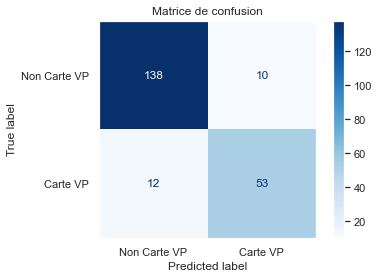

In [171]:
confusion_matrix = plot_confusion_matrix(XGBoost_cv.best_estimator_, X_test, y_test,
                             display_labels=["Non Carte VP", "Carte VP"],
                             cmap=plt.cm.Blues)
confusion_matrix.ax_.set_title("Matrice de confusion")
plt.grid(b=None)

### Analyse du modèle Gradient Boosting

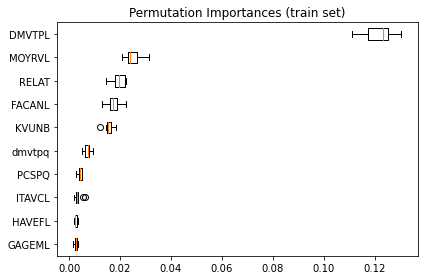

In [89]:
from sklearn.inspection import permutation_importance
feature_importances = permutation_importance(XGBoost_cv, X_train, y_train, n_repeats=10)
sorted_idx = feature_importances.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx][-10:].T,
           vert=False, labels=X_train.columns[sorted_idx][-10:])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

#### KMeans

In [173]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=2)
pipeline_kmeans=make_pipeline(preprocessor,kmeans)
pipeline_kmeans.fit(X)
predicted_clusters=pipeline_kmeans.predict(X)
data_class=data
data_class['c_kmeans']=predicted_clusters

C:\Users\Public\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


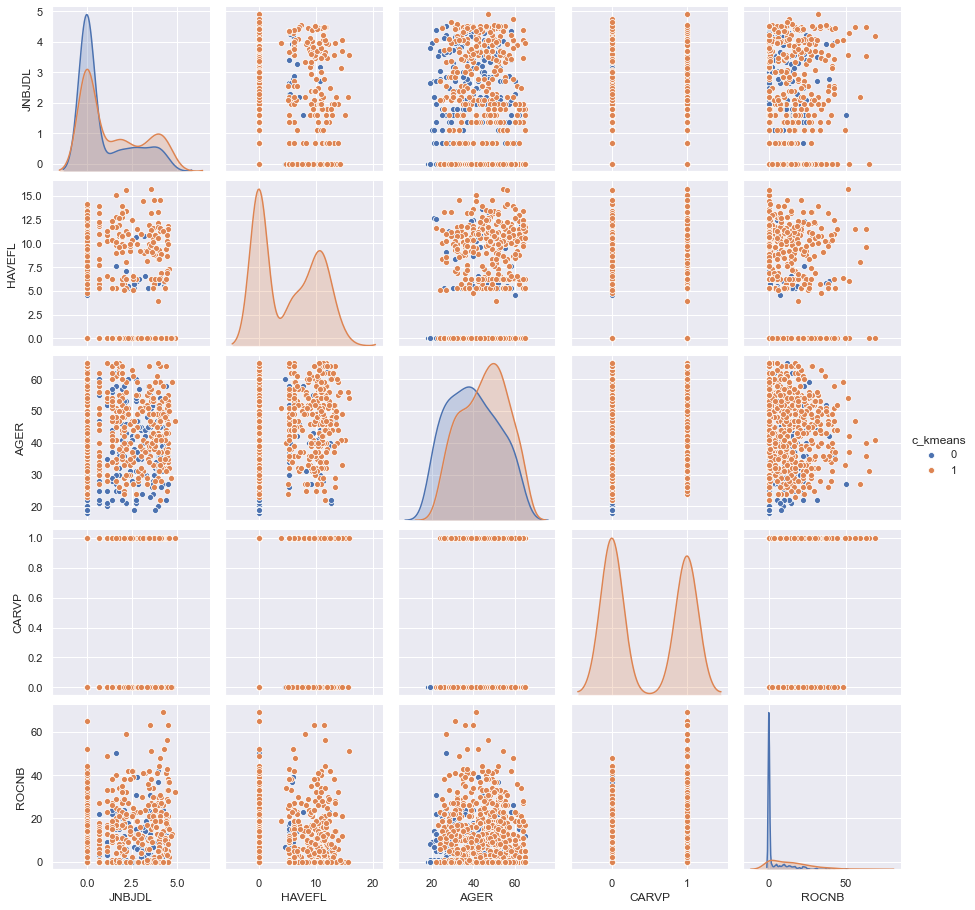

In [174]:
import seaborn as sns
sns.pairplot(data_class[["JNBJDL", "HAVEFL", "AGER", "CARVP", "ROCNB","c_kmeans"]], hue="c_kmeans");